In [1]:
# Import modules
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler


In [2]:
# Load dataset
twitter_cleaned = pd.read_csv("cleaned_twitter.csv", low_memory = False)
#display(twitter_cleaned)

# Drop all columns used to construct subjectivity index
twitter_cleaned = twitter_cleaned.drop(columns=['exmark_combined', 'first', 'interj','slang', 'sentiment', 'active_vb','semi_combined'])
twitter_cleaned

,sub_index,utype,domain,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
0,1.503432,between100-10msgs,Technology,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,1.657895,1.210526,0.785714,0.710526,0.687970,3.0,2.0,0.0
1,3.266043,morethan100msgs,Fitness,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,3.363636,1.284091,1.000000,1.000000,1.000000,5.0,2.0,3.0
2,0.000000,morethan100msgs,Technology,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,1.000000,0.000000,0.000000,0.600000,1.000000,2.0,2.0,0.0
3,2.892857,Random,Unknown,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,1.285714,1.714286,1.000000,0.857143,0.857143,5.0,3.0,4.0
4,2.595833,between10-3msgs,Technology,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,0.687500,1.072917,0.750000,0.437500,0.416667,8.5,2.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,mentioned,Science,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,1.066667,2.233333,1.000000,0.666667,1.000000,6.0,3.5,4.0
4499,3.482211,morethan100msgs,Fitness,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,3.846098,0.108217,0.093052,0.622591,0.003899,2.5,2.0,2.0
4500,0.000000,friend,Fitness,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0,2.0,0.0
4501,4.485965,mentioned,Science,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,0.000000,1.147368,0.815789,0.000000,0.636842,7.5,2.0,6.0


In [3]:
twitter_cleaned.groupby('domain').mean()['sub_index']



domain
Business      1.995392
Fitness       2.112803
Science       2.110410
Technology    1.716705
Unknown       2.561617
Name: sub_index, dtype: float64

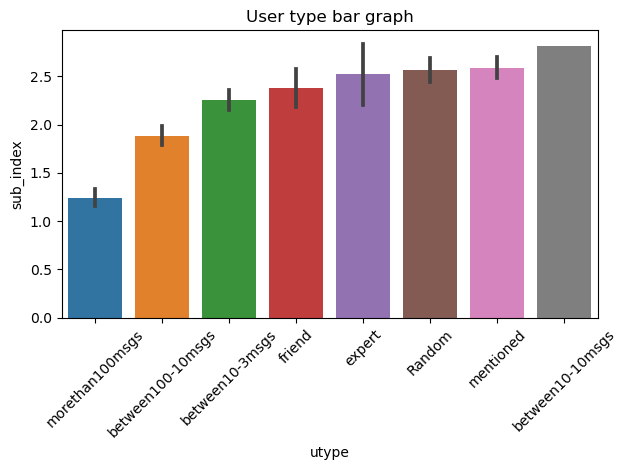

In [4]:
order = twitter_cleaned.groupby(["utype"])["sub_index"].mean().sort_values().index
sns.barplot(x="utype",
            y="sub_index",
            order = order,      
            data=twitter_cleaned)

plt.title("User type bar graph")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regression_graphs/utype_bar.png')
plt.savefig('regression_graphs/utype_bar.pdf')
plt.show()

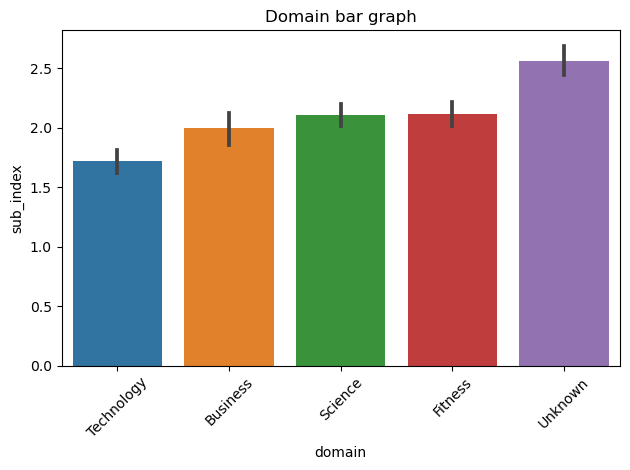

In [5]:
order = twitter_cleaned.groupby(["domain"])["sub_index"].mean().sort_values().index
sns.barplot(x="domain",
            y="sub_index", 
            order = order,    
            data=twitter_cleaned)

plt.title("Domain bar graph")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regression_graphs/domain_bar.png')
plt.savefig('regression_graphs/domain_bar.pdf')
plt.show()

In [6]:
# Checking subjectivity index properties
print(min(twitter_cleaned['sub_index']))
print(max(twitter_cleaned['sub_index']))
print(np.mean(twitter_cleaned['sub_index']))

-4.0
18.0
2.1266694884148367


In [7]:
subIndex_df = twitter_cleaned['sub_index']

# Construct relevant dataframe with label


In [8]:
regression_df = twitter_cleaned
# regression_df = twitter_cleaned.set_index('sub_index')
#regression_df = regression_df.sort_values('sub_index')

# Temp drop inf values (Discuss significance of dropping before or after labelling)
regression_df.replace([np.inf, -np.inf], np.nan, inplace=True)
regression_df.dropna(inplace=True)

# Convert utype and domain categorical data into encoded values
#ohe1, ohe2 = OneHotEncoder(), OneHotEncoder()
#utype_encoded = ohe1.fit_transform(regression_df[['utype']])
#domain_encoded = ohe2.fit_transform(regression_df[['domain']])

# Append new encoded categories into subIndex_df
#UTYPE_FEATURES = ohe1.categories_[0]
#DOMAIN_FEATURES = ohe2.categories_[0]
#regression_df[UTYPE_FEATURES] = utype_encoded.toarray()
#regression_df[DOMAIN_FEATURES] = domain_encoded.toarray()

#print(UTYPE_FEATURES, DOMAIN_FEATURES)
#regression_df = regression_df.drop(columns=['utype', 'domain','Random','between10-10msgs','between10-3msgs', 'between100-10msgs',
 # 'friend', 'mentioned', 'morethan100msgs','Unknown'])

# we drop utype and domain because they are not continuous. 
# The feature selection process of the regression model does not allow proper discretisation of categorical variables as DV, 
# so we leave utype and domain in decision-tree analysis 

regression_df = regression_df.drop(columns=['utype', 'domain'])
regression_df 

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
0,1.503432,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,1.657895,1.210526,0.785714,0.710526,0.687970,3.0,2.0,0.0
1,3.266043,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,3.363636,1.284091,1.000000,1.000000,1.000000,5.0,2.0,3.0
2,0.000000,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,1.000000,0.000000,0.000000,0.600000,1.000000,2.0,2.0,0.0
3,2.892857,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,1.285714,1.714286,1.000000,0.857143,0.857143,5.0,3.0,4.0
4,2.595833,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,0.687500,1.072917,0.750000,0.437500,0.416667,8.5,2.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,1.066667,2.233333,1.000000,0.666667,1.000000,6.0,3.5,4.0
4499,3.482211,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,3.846098,0.108217,0.093052,0.622591,0.003899,2.5,2.0,2.0
4500,0.000000,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0,2.0,0.0
4501,4.485965,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,0.000000,1.147368,0.815789,0.000000,0.636842,7.5,2.0,6.0


# Correlation
Identify correlation before Multiple Regression can be processed

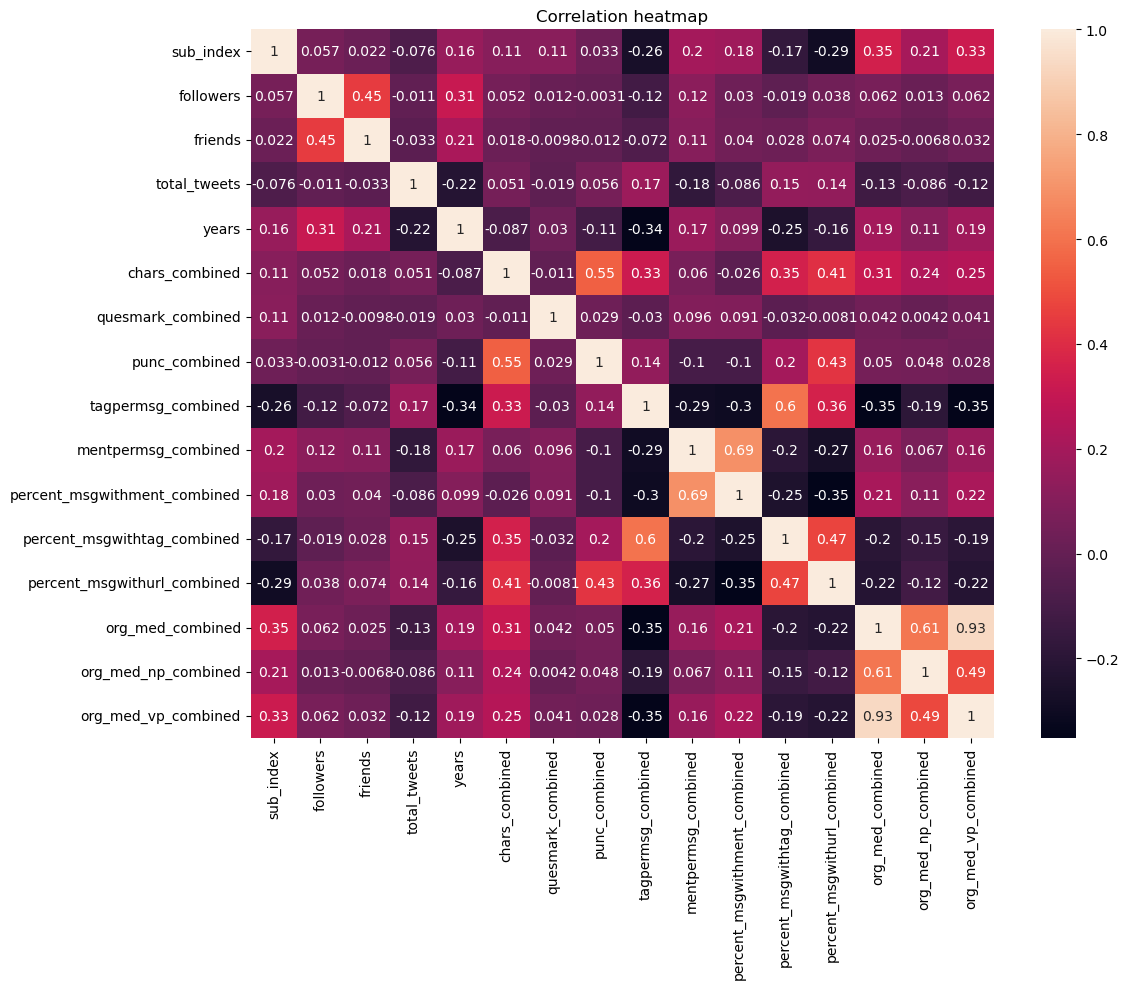

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(regression_df.corr(), annot=True)

plt.title("Correlation heatmap")
plt.tight_layout()
plt.savefig('regression_graphs/correlation_heatmap.png')
plt.savefig('regression_graphs/correlation_heatmap.pdf')
plt.show()

# Feature Selection

In [10]:
FEATURES = list(regression_df.columns.values)
FEATURES.remove('sub_index')
X = regression_df[FEATURES]
y = regression_df['sub_index'] 

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

result_r2 = []
result_mse = []
max_len = len(list(X_train.columns.values))
for i in range(max_len-1):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    model = model.get_robustcov_results(cov_type='HC1', use_t=None)
    #display(model.summary())

    r2 = model.rsquared
    mse = model.mse_resid

    result_r2.append(r2)
    result_mse.append(mse)

    p_list = list(model.pvalues)[1:]
    #print(p_list)
    max_p_value = max(p_list)
    max_index = p_list.index(max_p_value)
    #display(max_p_value, max_index)
    feature_names = list(X_train.columns.values)
    X_train = X_train.drop(feature_names[max_index+1], axis = 1)
    X_test = X_test.drop(feature_names[max_index+1], axis = 1)
    
print(result_r2)
print(result_mse)

result_r2


[0.22973206643718225, 0.22973060180961824, 0.22969884040953725, 0.22966937054120473, 0.2295325769045108, 0.22904095259997503, 0.22888711621417668, 0.2283341820349689, 0.2270393621492831, 0.22436117582937964, 0.2228783152546484, 0.21299746354739513, 0.2002165567527987, 0.11896603033023101]
[2.314828381656953, 2.3141874436931147, 2.3136378608605526, 2.3130817034756816, 2.312848028622756, 2.3136793451286137, 2.3134967657447523, 2.3145113299533158, 2.317749900189929, 2.3251335882134496, 2.3289309364155275, 2.3578868453933453, 2.395512909395473, 2.638141418196892]


[0.22973206643718225,
 0.22973060180961824,
 0.22969884040953725,
 0.22966937054120473,
 0.2295325769045108,
 0.22904095259997503,
 0.22888711621417668,
 0.2283341820349689,
 0.2270393621492831,
 0.22436117582937964,
 0.2228783152546484,
 0.21299746354739513,
 0.2002165567527987,
 0.11896603033023101]

/usr/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


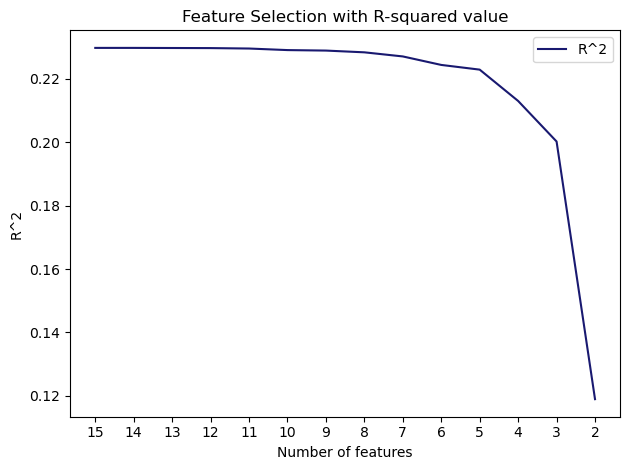

In [11]:

line_plot = sns.lineplot([15,14,13,12,11,10,9,8,7,6,5,4,3,2],result_r2, color = "midnightblue", label = "R^2")

line_plot.set_xticks([15,14,13,12,11,10,9,8,7,6,5,4,3,2])

line_plot.invert_xaxis()
plt.xlabel("Number of features")
plt.ylabel("R^2")
plt.title("Feature Selection with R-squared value")
plt.tight_layout()
plt.savefig('regression_graphs/fea_selection_r2.png')
plt.savefig('regression_graphs/fea_selection_r2.pdf')
plt.show()

/usr/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


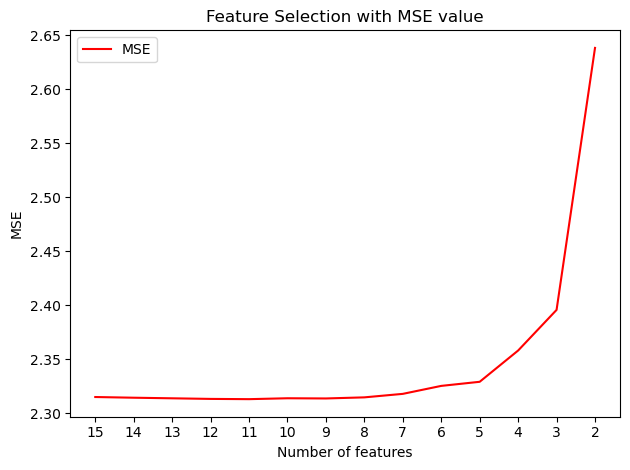

In [12]:
line_plot = sns.lineplot([15,14,13,12,11,10,9,8,7,6,5,4,3,2],result_mse, color = "red", label = "MSE")

line_plot.set_xticks([15,14,13,12,11,10,9,8,7,6,5,4,3,2])

line_plot.invert_xaxis()
plt.xlabel("Number of features")
plt.ylabel("MSE")
plt.title("Feature Selection with MSE value")
plt.tight_layout()
plt.savefig('regression_graphs/fea_selection_mse.png')
plt.savefig('regression_graphs/fea_selection_mse.pdf')
plt.show()

# Linear Regression


In [13]:
X = regression_df[FEATURES]
y = regression_df['sub_index'] 

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

result_r2 = []
result_mse = []
max_len = len(list(X_train.columns.values))
for i in range(11):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    model = model.get_robustcov_results(cov_type='HC1', use_t=None)
    #display(model.summary())

    r2 = model.rsquared
    mse = model.mse_resid

    result_r2.append(r2)
    result_mse.append(mse)

    p_list = list(model.pvalues)[1:]
    #print(p_list)
    max_p_value = max(p_list)
    max_index = p_list.index(max_p_value)
    #display(max_p_value, max_index)
    feature_names = list(X_train.columns.values)
    X_train = X_train.drop(feature_names[max_index+1], axis = 1)
    X_test = X_test.drop(feature_names[max_index+1], axis = 1)
    
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sub_index   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     172.6
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          5.79e-165
Time:                        10:40:35   Log-Likelihood:                -6630.6
No. Observations:                3602   AIC:                         1.327e+04
Df Residuals:                    3596   BIC:                         1.331e+04
Df Model:                           5                                         
Covariance Type:                  HC1                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.6663      0.123      5.398      0.000       0.424       0.908
chars_combined                  0.0181      0.002     11.345      0.000       0.015       0.021
quesmark_combined               0.6801      0.121      5.605      0.000       0.442       0.918
tagpermsg_combined             -0.1898      0.015    -12.423      0.000      -0.220      -0.160
percent_msgwithurl_combined    -1.2572      0.095    -13.192      0.000      -1.444      -1.070
org_med_combined                0.1001      0.019      5.184      0.000       0.062       0.138
==============================================================================
Omnibus:                     1472.017   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12544.387
Skew:                           1.718   Prob(JB):                         0.00
Kurtosis:                      11.472   Cond. No.                         504.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [14]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                &    sub\_index    & \textbf{  R-squared:         } &     0.223   \\
\textbf{Model:}                        &       OLS        & \textbf{  Adj. R-squared:    } &     0.222   \\
\textbf{Method:}                       &  Least Squares   & \textbf{  F-statistic:       } &     172.6   \\
\textbf{Date:}                         & Sun, 13 Nov 2022 & \textbf{  Prob (F-statistic):} & 5.79e-165   \\
\textbf{Time:}                         &     10:40:35     & \textbf{  Log-Likelihood:    } &   -6630.6   \\
\textbf{No. Observations:}             &        3602      & \textbf{  AIC:               } & 1.327e+04   \\
\textbf{Df Residuals:}                 &        3596      & \textbf{  BIC:               } & 1.331e+04   \\
\textbf{Df Model:}                     &           5      & \textbf{                     } &             \\
\textbf{Covariance Type:}              &       HC1        & \textbf{                     }

# K-Fold

In [15]:

X = regression_df[['chars_combined','quesmark_combined','tagpermsg_combined','percent_msgwithurl_combined','org_med_combined']]
y = regression_df['sub_index'] 
X = sm.add_constant(X)


#print(X.shape)
X

,const,chars_combined,quesmark_combined,tagpermsg_combined,percent_msgwithurl_combined,org_med_combined
0,1.0,100.669173,0.131579,1.657895,0.687970,3.0
1,1.0,132.244318,0.073864,3.363636,1.000000,5.0
2,1.0,61.200000,0.000000,1.000000,1.000000,2.0
3,1.0,139.857143,0.142857,1.285714,0.857143,5.0
4,1.0,129.625000,0.062500,0.687500,0.416667,8.5
...,...,...,...,...,...,...
4498,1.0,120.600000,0.066667,1.066667,1.000000,6.0
4499,1.0,118.715223,0.066431,3.846098,0.003899,2.5
4500,1.0,51.000000,0.000000,2.000000,1.000000,2.0
4501,1.0,117.094737,0.436842,0.000000,0.636842,7.5


In [16]:
# set k=5 value for k-fold CV
k = 10

kf_CV = KFold(n_splits=k, shuffle=True, random_state=42)
results_r2 = []
results_mse = []

In [17]:
for train_idx, test_idx in kf_CV.split(X):
    #print(train_idx)
    #print(test_idx)
    # train-test split
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = sm.OLS(y_train, X_train).fit()
    model = model.get_robustcov_results(cov_type='HC1', use_t=None)
   
    r2 = model.rsquared
    mse = model.mse_resid
    
    results_r2.append(r2)
    results_mse.append(mse)

print(np.mean(results_r2))
print(np.mean(results_mse))
results_r2

0.22443950747786875
2.344393030272638


[0.22740128763002643,
 0.22048283353175435,
 0.2192312455950286,
 0.22180647575937262,
 0.21600043180234474,
 0.2261835480375458,
 0.2358217631101509,
 0.22420161674319228,
 0.22699427749940304,
 0.22627159506986905]

# Scatter plot before removing outliers

## chars_combined

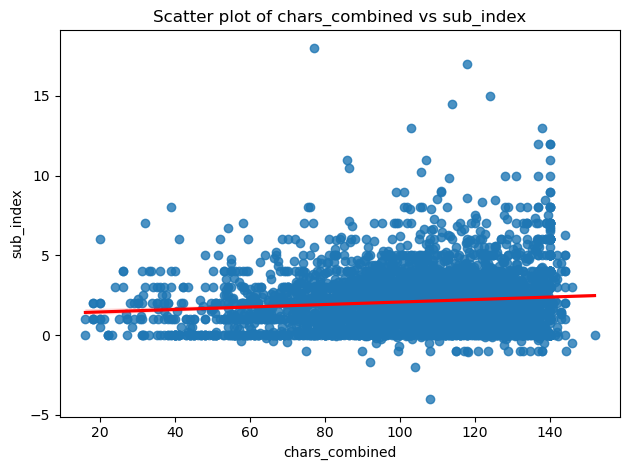

In [18]:
sns.regplot(x="chars_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=regression_df)

plt.title("Scatter plot of chars_combined vs sub_index")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_chars_combined.png')
plt.savefig('regression_graphs/scatterplot_chars_combined.pdf')
plt.show()

## quesmark_combined

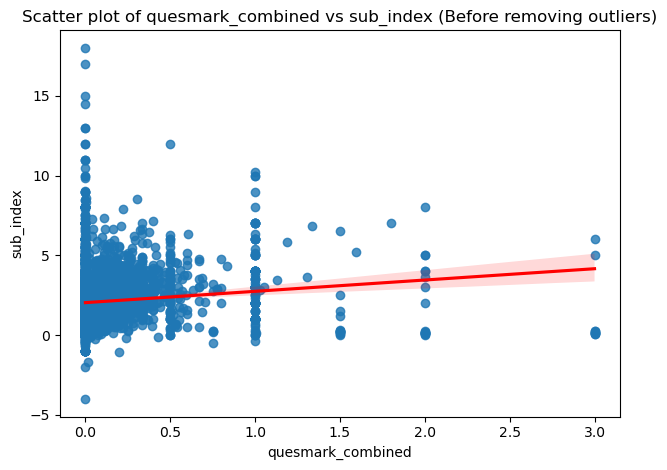

In [19]:
sns.regplot(x="quesmark_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=regression_df)

plt.title("Scatter plot of quesmark_combined vs sub_index (Before removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_quesmark_combined_before_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_quesmark_combined_before_removing_outliers.pdf')
plt.show()

## tagpermsg_combined

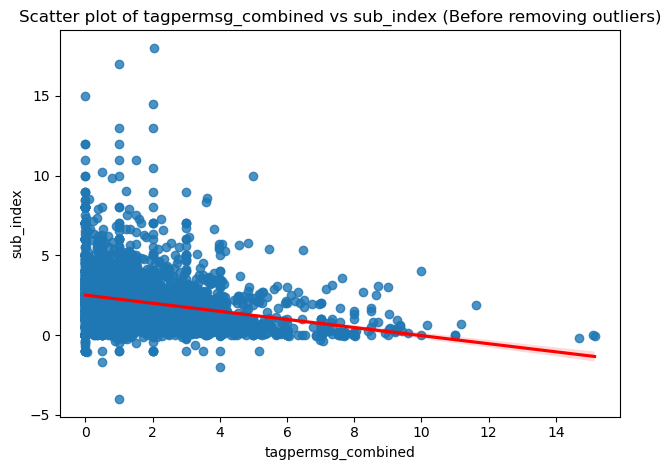

In [20]:
sns.regplot(x="tagpermsg_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=regression_df)

plt.title("Scatter plot of tagpermsg_combined vs sub_index (Before removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_tagpermsg_combined_before_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_tagpermsg_combined_before_removing_outliers.pdf')
plt.show()

## percent_msgwithurl_combined

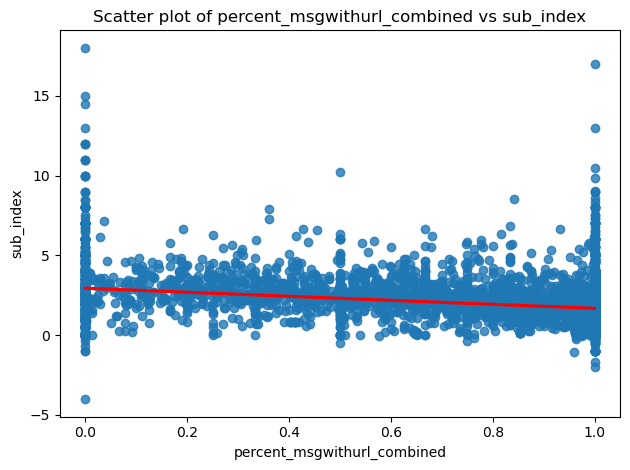

In [21]:
sns.regplot(x="percent_msgwithurl_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=regression_df)

plt.title("Scatter plot of percent_msgwithurl_combined vs sub_index")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_percent_msgwithurl_combined.png')
plt.savefig('regression_graphs/scatterplot_percent_msgwithurl_combined.pdf')
plt.show()

## org_med_combined

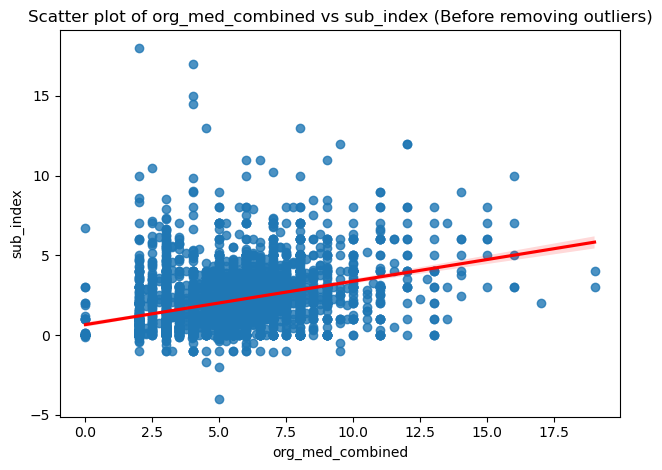

In [22]:
sns.regplot(x="org_med_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=regression_df)

plt.title("Scatter plot of org_med_combined vs sub_index (Before removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_org_med_combined_before_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_org_med_combined_before_removing_outliers.pdf')
plt.show()

# Scatter plot after removing outlier

In [23]:
def outlier_IQR(df):
    '''
    This function calculates the far lower and far upper fence 
    based on 3 IQR distance from Q3 and Q1
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR = Q3 - Q1
    far_upper_fence = Q3 + 3 * IQR
    far_lower_fence = Q1 - 3 * IQR
    return far_lower_fence, far_upper_fence

## chars_combined

In [24]:
# The far upper and far lower fences are calculated for followers 
chars_combined_lower_fence, chars_combined_upper_fence = outlier_IQR(regression_df['chars_combined'])
chars_combined_lower_fence, chars_combined_upper_fence

(-3.5178677150000084, 221.14684378)

In [25]:
# The data exceeding the fences is considered as outliers and is listed below
chars_combined_outliers = regression_df[(regression_df.chars_combined < chars_combined_lower_fence) | (regression_df.chars_combined > chars_combined_upper_fence)]
chars_combined_outliers = pd.DataFrame(chars_combined_outliers)
chars_combined_outliers

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined


There are no outliers to be removed for chars_combined feature

## quesmark_combined

In [26]:
# The far upper and far lower fences are calculated for followers 
quesmark_combined_lower_fence, quesmark_combined_upper_fence = outlier_IQR(regression_df['quesmark_combined'])
quesmark_combined_lower_fence, quesmark_combined_upper_fence

(-0.3992753625, 0.53236715)

In [27]:
# The data exceeding the fences is considered as outliers and is listed below
quesmark_combined_outliers = regression_df[(regression_df.quesmark_combined < quesmark_combined_lower_fence) | (regression_df.quesmark_combined > quesmark_combined_upper_fence)]
quesmark_combined_outliers = pd.DataFrame(quesmark_combined_outliers)
quesmark_combined_outliers

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
22,0.245491,20.0,81.0,270.0,1.756164,96.591418,0.751866,3.527985,3.826493,1.005597,0.750000,0.736940,0.735075,2.0,2.0,0.00
34,6.315789,11063.0,437.0,20.0,5.060274,129.105263,0.605263,2.789474,0.263158,1.263158,0.657895,0.631579,0.815789,10.0,6.0,8.50
41,0.687057,1215.0,1465.0,377.0,2.087671,131.250000,1.000000,3.759309,2.731383,3.492021,1.000000,1.000000,1.000000,6.5,2.0,10.00
42,1.000000,7650.0,392.0,1.0,6.263014,140.000000,1.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,6.0,2.0,5.00
54,0.131419,10.0,16.0,268.0,1.728767,85.516917,1.501880,3.537594,3.695489,1.505639,1.000000,0.977444,0.969925,2.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4340,2.000000,75.0,202.0,2.0,1.668493,94.500000,1.000000,2.000000,0.500000,0.500000,0.500000,0.500000,0.500000,4.0,3.0,2.00
4424,0.000000,251.0,1123.0,1.0,6.819178,50.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.0,3.0,0.00
4453,3.000000,2478.0,132.0,1.0,4.564384,53.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,8.0,2.0,7.00
4459,3.553571,4629.0,1515.0,9.0,6.783562,108.937500,0.687500,5.250000,0.687500,1.562500,0.937500,0.687500,0.625000,6.0,2.5,4.75


In [28]:
# The outliers are removed from original dataset
quesmark_combined_outliers_dropped = regression_df.drop(quesmark_combined_outliers.index)
quesmark_combined_outliers_dropped

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
0,1.503432,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,1.657895,1.210526,0.785714,0.710526,0.687970,3.0,2.0,0.0
1,3.266043,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,3.363636,1.284091,1.000000,1.000000,1.000000,5.0,2.0,3.0
2,0.000000,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,1.000000,0.000000,0.000000,0.600000,1.000000,2.0,2.0,0.0
3,2.892857,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,1.285714,1.714286,1.000000,0.857143,0.857143,5.0,3.0,4.0
4,2.595833,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,0.687500,1.072917,0.750000,0.437500,0.416667,8.5,2.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,1.066667,2.233333,1.000000,0.666667,1.000000,6.0,3.5,4.0
4499,3.482211,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,3.846098,0.108217,0.093052,0.622591,0.003899,2.5,2.0,2.0
4500,0.000000,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0,2.0,0.0
4501,4.485965,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,0.000000,1.147368,0.815789,0.000000,0.636842,7.5,2.0,6.0


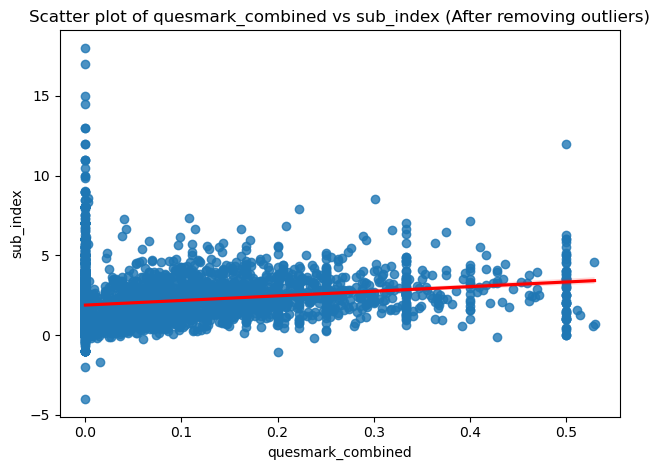

In [29]:
sns.regplot(x="quesmark_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=quesmark_combined_outliers_dropped)

plt.title("Scatter plot of quesmark_combined vs sub_index (After removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_quesmark_combined_after_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_quesmark_combined_after_removing_outliers.pdf')
plt.show()

## tagpermsg_combined

In [30]:
# The far upper and far lower fences are calculated for followers 
tagpermsg_combined_lower_fence, tagpermsg_combined_upper_fence = outlier_IQR(regression_df['tagpermsg_combined'])
tagpermsg_combined_lower_fence, tagpermsg_combined_upper_fence

(-5.295192308, 7.471394231)

In [31]:
# The data exceeding the fences is considered as outliers and is listed below
tagpermsg_combined_outliers = regression_df[(regression_df.tagpermsg_combined < tagpermsg_combined_lower_fence) | (regression_df.tagpermsg_combined > tagpermsg_combined_upper_fence)]
tagpermsg_combined_outliers = pd.DataFrame(tagpermsg_combined_outliers)
tagpermsg_combined_outliers

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
7,1.333333,435.0,432.0,6.0,2.936986,126.333333,0.000000,0.666667,8.000000,0.000000,0.0,1.0,0.000000,6.5,2.0,5.5
14,0.183673,29.0,285.0,97.0,1.761644,139.525773,0.000000,4.907216,7.721649,1.000000,1.0,1.0,1.000000,2.0,2.0,0.0
25,0.138641,16.0,168.0,93.0,1.676712,138.623656,0.000000,4.935484,7.602151,1.000000,1.0,1.0,1.000000,2.0,2.0,0.0
32,0.125219,15.0,156.0,95.0,1.673973,138.884210,0.000000,4.863158,7.715789,1.000000,1.0,1.0,1.000000,2.0,2.0,0.0
106,0.063830,23.0,224.0,94.0,1.671233,139.393617,0.000000,4.872340,7.670213,1.000000,1.0,1.0,1.000000,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,0.127660,25.0,222.0,94.0,1.684932,139.436170,0.000000,4.872340,7.627660,1.000000,1.0,1.0,1.000000,2.0,2.0,0.0
4329,0.285024,175.0,85.0,275.0,0.616438,125.761628,0.023256,2.401163,8.416605,1.534884,1.0,1.0,1.000000,2.0,2.0,0.0
4425,0.714286,102.0,64.0,9.0,2.326027,100.583333,0.000000,3.083333,11.166667,1.000000,1.0,1.0,1.000000,3.0,2.0,2.0
4433,0.441176,515.0,1676.0,34.0,1.706849,134.147059,0.000000,3.294118,9.058824,0.000000,0.0,1.0,0.970588,3.0,2.0,0.0


In [32]:
# The outliers are removed from original dataset
tagpermsg_combined_outliers_dropped = regression_df.drop(tagpermsg_combined_outliers.index)
tagpermsg_combined_outliers_dropped

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
0,1.503432,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,1.657895,1.210526,0.785714,0.710526,0.687970,3.0,2.0,0.0
1,3.266043,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,3.363636,1.284091,1.000000,1.000000,1.000000,5.0,2.0,3.0
2,0.000000,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,1.000000,0.000000,0.000000,0.600000,1.000000,2.0,2.0,0.0
3,2.892857,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,1.285714,1.714286,1.000000,0.857143,0.857143,5.0,3.0,4.0
4,2.595833,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,0.687500,1.072917,0.750000,0.437500,0.416667,8.5,2.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,1.066667,2.233333,1.000000,0.666667,1.000000,6.0,3.5,4.0
4499,3.482211,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,3.846098,0.108217,0.093052,0.622591,0.003899,2.5,2.0,2.0
4500,0.000000,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0,2.0,0.0
4501,4.485965,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,0.000000,1.147368,0.815789,0.000000,0.636842,7.5,2.0,6.0


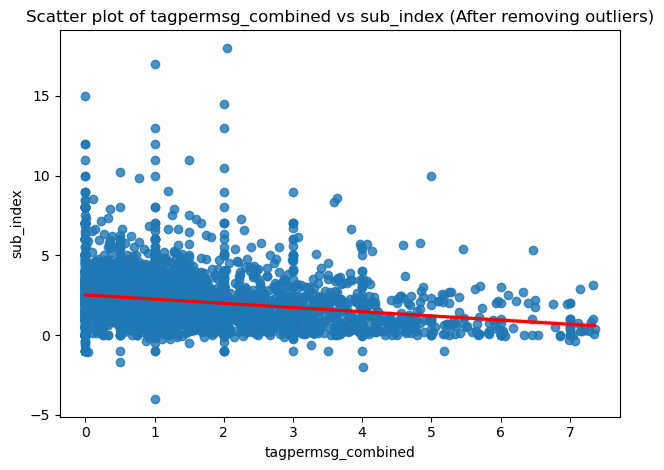

In [33]:
sns.regplot(x="tagpermsg_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=tagpermsg_combined_outliers_dropped)

plt.title("Scatter plot of tagpermsg_combined vs sub_index (After removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_tagpermsg_combined_after_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_tagpermsg_combined_after_removing_outliers.pdf')
plt.show()

## percent_msgwithurl_combined

In [34]:
# The far upper and far lower fences are calculated for followers 
percent_msgwithurl_combined_lower_fence, percent_msgwithurl_combined_upper_fence = outlier_IQR(regression_df['percent_msgwithurl_combined'])
percent_msgwithurl_combined_lower_fence, percent_msgwithurl_combined_upper_fence

(-1.9509569369999997, 3.2132177027499997)

In [35]:
# The data exceeding the fences is considered as outliers and is listed below
percent_msgwithurl_combined_outliers = regression_df[(regression_df.percent_msgwithurl_combined < percent_msgwithurl_combined_lower_fence) | (regression_df.percent_msgwithurl_combined > percent_msgwithurl_combined_upper_fence)]
percent_msgwithurl_combined_outliers = pd.DataFrame(percent_msgwithurl_combined_outliers)
percent_msgwithurl_combined_outliers

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined


There are no outliers to be removed for percent_msgwithurl_combined feature

## org_med_combined

In [36]:
# The far upper and far lower fences are calculated for followers 
org_med_combined_lower_fence, org_med_combined_upper_fence = outlier_IQR(regression_df['org_med_combined'])
org_med_combined_lower_fence, org_med_combined_upper_fence

(-3.5, 14.0)

In [37]:
# The data exceeding the fences is considered as outliers and is listed below
org_med_combined_outliers = regression_df[(regression_df.org_med_combined < org_med_combined_lower_fence) | (regression_df.org_med_combined > org_med_combined_upper_fence)]
org_med_combined_outliers = pd.DataFrame(org_med_combined_outliers)
org_med_combined_outliers

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
248,7.0,641.0,953.0,1.0,6.183562,140.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,15.0,13.0,14.0
759,6.0,18.0,76.0,1.0,1.276712,105.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,15.0,2.0,14.0
1413,3.0,2992.0,2518.0,1.0,6.769863,146.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,19.0,13.0,18.0
1428,4.0,479.0,331.0,1.0,3.786301,116.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,19.0,5.0,18.0
1974,5.0,1095.0,1048.0,1.0,6.473973,140.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,16.0,2.0,15.0
2106,3.0,96.0,107.0,1.0,1.238356,133.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,16.0,14.0,15.0
2570,10.0,4714.0,2666.0,1.0,3.438356,137.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,16.0,14.0,15.0
2777,3.0,878.0,964.0,1.0,3.967123,120.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,16.0,15.0,15.0
3033,5.0,649.0,412.0,1.0,5.980822,140.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,15.0,2.0,13.0
3128,8.0,1012.0,1997.0,1.0,3.520548,137.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,15.0,13.0,14.0


In [38]:
# The outliers are removed from original dataset
org_med_combined_outliers_dropped = regression_df.drop(org_med_combined_outliers.index)
org_med_combined_outliers_dropped

,sub_index,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,mentpermsg_combined,percent_msgwithment_combined,percent_msgwithtag_combined,percent_msgwithurl_combined,org_med_combined,org_med_np_combined,org_med_vp_combined
0,1.503432,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,1.657895,1.210526,0.785714,0.710526,0.687970,3.0,2.0,0.0
1,3.266043,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,3.363636,1.284091,1.000000,1.000000,1.000000,5.0,2.0,3.0
2,0.000000,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,1.000000,0.000000,0.000000,0.600000,1.000000,2.0,2.0,0.0
3,2.892857,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,1.285714,1.714286,1.000000,0.857143,0.857143,5.0,3.0,4.0
4,2.595833,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,0.687500,1.072917,0.750000,0.437500,0.416667,8.5,2.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,1.066667,2.233333,1.000000,0.666667,1.000000,6.0,3.5,4.0
4499,3.482211,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,3.846098,0.108217,0.093052,0.622591,0.003899,2.5,2.0,2.0
4500,0.000000,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0,2.0,0.0
4501,4.485965,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,0.000000,1.147368,0.815789,0.000000,0.636842,7.5,2.0,6.0


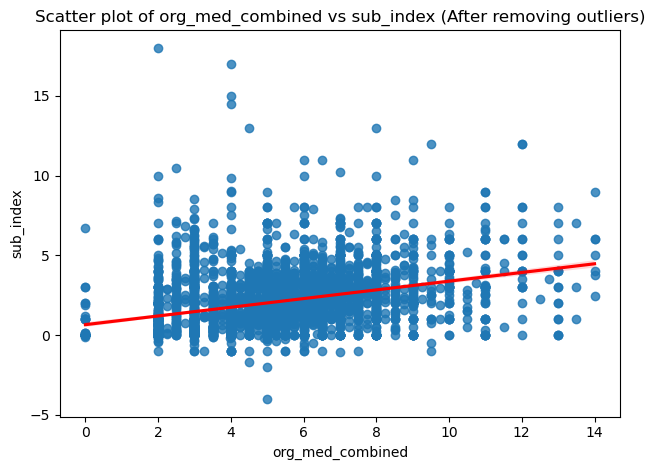

In [39]:
sns.regplot(x="org_med_combined",
            y="sub_index", 
            line_kws={"color": "red"},
            data=org_med_combined_outliers_dropped)

plt.title("Scatter plot of org_med_combined vs sub_index (After removing outliers)")
plt.tight_layout()
plt.savefig('regression_graphs/scatterplot_org_med_combined_after_removing_outliers.png')
plt.savefig('regression_graphs/scatterplot_org_med_combined_after_removing_outliers.pdf')
plt.show()

## 